## Taller de agentes con LangGraph

En este taller práctico, crearemos un agente usando la librería LangGraph y modelos de OpenAI. Este agente tendrá dos herramientas a su disposición:

*   **Tavily**: para búsquedas web
*   **WeatherAPI**: para previsión del tiempo (o tiempo actual)

El agente detectará la intencionalidad de la pregunta, decidirá si debe usar alguna de estas herramientas, y devolverá una respuesta al usuario construida a partir de la información recuperada de estas APIs

### Instalamos las librerías necesarias: paquetes específicos de langchain

In [ ]:
!pip install -q langgraph langchain langchain-community langchain-openai python-dotenv

### Importamos las herramientas necesarias, que todas están integradas en langchain

In [3]:
import os
import requests
from typing import List, Literal
from langchain_community.tools.tavily_search import TavilySearchResults

#Forma de acceder a las APIs
from langchain_core.tools import tool

#Forma de conectarse a openAI
from langchain_openai import AzureChatOpenAI

### Definimos las APIs necesarias, tanto de OpenAI como de WeatherAPI

Recordemos que en una aplicación real, las APIs no deben quedar expuestas en el código

In [4]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
API_VERSION = userdata.get('OPENAI_API_VERSION')
AZURE_ENDPOINT = userdata.get('AZURE_OPENAI_ENDPOINT')
WEATHER_API_KEY = userdata.get('WEATHER_API_KEY')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

### Empezamos definiendo las tools (herramientas) que va a tener a su disposición el agente

Se usa el decorador @tool para indicarle a langchain que son herramientas. Al incluir este decorador, se extraen metadatos importantes como el nombre de la herramienta (que por defecto es el nombre de la función) y la descripción (el docstring de la función, la primera línea que se define entre comillas)


In [5]:
@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current or forecast weather""" #docstring para darle la descripción
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()

    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

@tool
def search_web(query: str) -> list:
    """Search the web for a query""" #docstring para darle la descripción
    tavily_search = TavilySearchResults(max_results=5, search_depth='advanced', max_tokens=1000)
    results = tavily_search.invoke(query)
    return results

### Probamos manualmente la API de get_weather

In [6]:
get_weather("Madrid")

/tmp/ipython-input-1715036385.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  get_weather("Madrid")


{'location': {'name': 'Madrid',
  'region': 'Madrid',
  'country': 'Spain',
  'lat': 40.4,
  'lon': -3.6833,
  'tz_id': 'Europe/Madrid',
  'localtime_epoch': 1759918884,
  'localtime': '2025-10-08 12:21'},
 'current': {'last_updated_epoch': 1759918500,
  'last_updated': '2025-10-08 12:15',
  'temp_c': 22.3,
  'temp_f': 72.1,
  'is_day': 1,
  'condition': {'text': 'Partly Cloudy',
   'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png',
   'code': 1003},
  'wind_mph': 2.7,
  'wind_kph': 4.3,
  'wind_degree': 199,
  'wind_dir': 'SSW',
  'pressure_mb': 1022.0,
  'pressure_in': 30.18,
  'precip_mm': 0.0,
  'precip_in': 0.0,
  'humidity': 41,
  'cloud': 0,
  'feelslike_c': 24.0,
  'feelslike_f': 75.2,
  'windchill_c': 23.8,
  'windchill_f': 74.8,
  'heatindex_c': 24.6,
  'heatindex_f': 76.2,
  'dewpoint_c': 8.7,
  'dewpoint_f': 47.6,
  'vis_km': 10.0,
  'vis_miles': 6.0,
  'uv': 2.5,
  'gust_mph': 3.1,
  'gust_kph': 5.0,
  'short_rad': 239.38,
  'diff_rad': 78.52,
  'dni': 529.36,
  'gt

### Probamos manualmente la API de Tavily

In [ ]:
search_web("¿Ultimo precio de accion de BBVA?")

In [ ]:
search_web("¿cuando inicia la temporada de la NFL 2026?")

### Llamamos al modelo con el parámetro bind_tools(), que permite pasar tools de Langchain para que las use el LLM

In [9]:
os.environ["AZURE_OPENAI_ENDPOINT"] = AZURE_ENDPOINT

llm = AzureChatOpenAI(azure_deployment="gpt-4o",
    api_key = OPENAI_API_KEY,
    api_version=API_VERSION,
    temperature=0.1,
    max_tokens=None,
    timeout=None,
    max_retries=2,)


In [ ]:

tools = [search_web, get_weather]

#bind_tools permite enchufarse las herramientas al LLM
llm_with_tools = llm.bind_tools(tools)

### El LLM por si mismo no tiene acceso a información en tiempo real

In [10]:
query = "What is the current weather in Segovia today?"
response = llm.invoke(query)
print(response.content)

I'm unable to provide real-time weather updates as my knowledge only goes up until October 2023 and I don't have access to live data. To find the current weather in Segovia, I recommend checking a reliable weather website or app like [Weather.com](https://weather.com) or using a weather service like AccuWeather or your phone's weather app.


In [11]:
query = "quien fue el campeon del super bowl en 2025?"
response = llm.invoke(query)
print(response.content)

¡No puedo predecir el futuro! Mi conocimiento llega hasta octubre de 2023, por lo que no tengo información sobre el campeón del Super Bowl en 2025. Te recomiendo consultar fuentes actualizadas como sitios web deportivos o noticias en ese momento para obtener la información más reciente. 😊🏈


### Podemos definir el prompt que se le pasará al LLM+tools, explicándole la tarea o tareas que queremos que haga

In [12]:
prompt = """
    Given the tools at your disposal, mention tool calls for the following tasks --If any answer can´t be provided from tool calls, use your own knowledge:
    Do not change the query given for any search tasks
        1. What is the current weather in Madrid today
        2. Can you tell me about Kerala
        3. Why is the sky blue?
    """

results = llm_with_tools.invoke(prompt)

print(results.tool_calls)

[{'name': 'get_weather', 'args': {'query': 'Madrid'}, 'id': 'call_C3ocHcuipVheApKLF19zCmyw', 'type': 'tool_call'}, {'name': 'search_web', 'args': {'query': 'Kerala'}, 'id': 'call_JKtydnnwrwbXHKQXfrbEzkCh', 'type': 'tool_call'}]


In [13]:
# Ha disenado el plan de accion
print(results)

content='' additional_kwargs={'tool_calls': [{'id': 'call_C3ocHcuipVheApKLF19zCmyw', 'function': {'arguments': '{"query": "Madrid"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_JKtydnnwrwbXHKQXfrbEzkCh', 'function': {'arguments': '{"query": "Kerala"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 149, 'total_tokens': 195, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-COLnnuoD821tlOyKNHsLjXFlUHUwu', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity

In [14]:
# Es vacio el contenido, porque aun no se ha materializado
results.content

''

### Ahora creamos el agente con grafos, usando LangGraph

En primer lugar, usamos el módulo create_react_agent. El paradigma ReAct está bastado en Reason & Act, es decir, razonar (¿qué tool tengo a mi disposición y cuál debería usar?) y actuar (voy a usar esta herramienta para que me devuelva una respuesta y analizarla)

In [15]:
from langgraph.prebuilt import create_react_agent

Creamos un system_prompt, donde le explicamos qué esperamos que haga, y las tools que tiene a su disposición. Es importante que los nombres de las tools coincidan con el nombre con el que le hemos definido, así como darle una buena explicación de su función

In [16]:
system_prompt = """Act as a helpful assistant.
    Use the tools at your disposal to perform tasks as needed.
        - get_weather: whenever user asks get the weather of a place.
        - search_web: whenever user asks for information on current events or if you don't know the answer.
    Use the tools only if you don't know the answer."""

### Inicializamos el agente con el modelo, las tools y el system_prompt

In [18]:
from langchain_core.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_messages([("system", system_prompt), ("placeholder", "{messages}")])

#Ahora estamos inicializando el agente con grafos, por eso no se utiliza el llm_with_tools directamente.
agent = create_react_agent(model=llm, tools=tools, prompt=prompt_template)

### Probamos el agente para ver qué hace

In [19]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "What is the current weather in Madrid today")]}

print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the current weather in Madrid today
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_b6eZpxo9xDPP2menO2Vcg8jS)
 Call ID: call_b6eZpxo9xDPP2menO2Vcg8jS
  Args:
    query: Madrid
================================= Tool Message =================================
Name: get_weather

{"location": {"name": "Madrid", "region": "Madrid", "country": "Spain", "lat": 40.4, "lon": -3.6833, "tz_id": "Europe/Madrid", "localtime_epoch": 1759920020, "localtime": "2025-10-08 12:40"}, "current": {"last_updated_epoch": 1759919400, "last_updated": "2025-10-08 12:30", "temp_c": 22.3, "temp_f": 72.1, "is_day": 1, "condition": {"text": "Sunny", "icon": "//cdn.weatherapi.com/weather/64x64/day/113.png", "code": 1000}, "wind_mph": 2.7, "wind_kph": 4.3, "wind_degree": 213, "wind_dir": "SSW", "pressure_mb": 1022.0, "pressure_in": 30.18, "precip_mm": 0.0, "precip_in

### Vamos a crear la lógica de grafos (estados y nodos)

En primer lugar, definimos el conjunto de tools posibles mediante el ToolNode

In [20]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

tools = [search_web, get_weather]
tool_node = ToolNode(tools)

Definimos las funciones para llamar al LLM y las tools. La función call_tools llevará al final (END)

In [21]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

Inicializamos el flow con StateGraph

In [22]:
workflow = StateGraph(MessagesState)

Ahora ya podemos añadir nodos. Primero, añadimos un nodo de LLM, que usará el LLM para tomar decisiones en base al input

In [23]:
workflow.add_node("LLM", call_model)

Nuestro flow comienza con el nodo LLM. Esto se codifica añadiendolo con la función add_edge, indicando que es START

In [24]:
workflow.add_edge(START, "LLM")

Después, pasamos por el nodo de las tools

In [25]:
workflow.add_node("tools", tool_node)

Añadimos un edge condicional, que va del LLM a las llamadas de las tools. Dependiendo del output del LLM, irá al nodo de tools o al final (END), según el agente considere que necesita consultar una de las tools o puede dar una respuesta autónoma

In [26]:
workflow.add_conditional_edges("LLM", call_tools)

Por último, el nodo tools le manda la información de vuelta al LLM

In [27]:
workflow.add_edge("tools", "LLM")

Cuando hemos definido todo nuestro flow, se debe compilar

In [28]:
agent = workflow.compile()

Se puede pintar el flow automáticamente

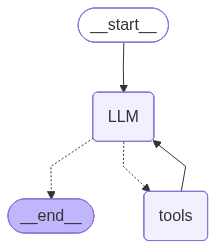

In [29]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

### Ya podemos usar nuestro agente y ver los pasos intermedios que sigue

In [30]:
for chunk in agent.stream(
    {"messages": [("user", "What was the stock price of BBVA in the Spanish market as of March 6th, 2025? And will I need an umbrella in Madrid for tomorrow? y quien fue el campeon del super bowl 2025?")]}, #"Will I need an umbrella in Madrid tomorrow?"
    stream_mode="values",):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What was the stock price of BBVA in the Spanish market as of March 6th, 2025? And will I need an umbrella in Madrid for tomorrow? y quien fue el campeon del super bowl 2025?
================================== Ai Message ==================================
Tool Calls:
  search_web (call_JCP9iLEiBz6PzUDprQ920sLu)
 Call ID: call_JCP9iLEiBz6PzUDprQ920sLu
  Args:
    query: BBVA stock price Spanish market March 6 2025
  get_weather (call_n3HMRsOz7ncgWDiwGgyoguMi)
 Call ID: call_n3HMRsOz7ncgWDiwGgyoguMi
  Args:
    query: Madrid weather tomorrow
  search_web (call_31FpL1ffZkxN7o8nzpJAIRDg)
 Call ID: call_31FpL1ffZkxN7o8nzpJAIRDg
  Args:
    query: Super Bowl 2025 champion
================================= Tool Message =================================
Name: search_web

[{"title": "Super Bowl LIX", "url": "https://en.wikipedia.org/wiki/Super_Bowl_LIX", "content": "[Jump to content](https://en.wikipedia.org/wiki/S